In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import os

data_path = "/kaggle/input/"
# data_path = "../data/raw"
print(os.listdir(data_path))

['articles2.csv', 'articles3.csv', 'articles1.csv']


In [3]:
df1 = pd.read_csv(f'{data_path}/articles1.csv')
df2 = pd.read_csv(f'{data_path}/articles2.csv')
df3 = pd.read_csv(f'{data_path}/articles3.csv')

In [4]:
dff = pd.concat([df1,df2,df3])
dff = dff[['publication', 'content']]
dff.shape

(142570, 2)

In [5]:
media_outlets = dff['publication'].unique()

In [6]:
media_bias = {
    "Breitbart": "Right",
    "New York Post": "Lean Right",
    "NPR": "Lean Left",
    "CNN": "Lean Left",
    "Washington Post": "Lean Left",
    "Reuters": "Center",
    "Guardian": "Left",
    "New York Times": "Lean Left",
    "Atlantic": "Left",
    "Business Insider": "Lean Left",
    "National Review": "Lean Right",
    "Talking Points Memo": "NA",
    "Vox": "Left",
    "Buzzfeed News": "NA",
    "Fox News": "Right"
}

In [7]:
media_data = dff.sample(frac=1)

In [8]:
for media_outlet in media_outlets:
  if media_bias[media_outlet] and media_bias[media_outlet] != "NA":
    media_data.loc[media_data['publication'] == media_outlet, 'publication'] = media_bias[media_outlet]
  else:
    media_data = media_data[media_data['publication'] != media_outlet]

media_data = media_data.rename(columns={'publication': 'bias'})
media_data['bias'].value_counts()

bias
Lean Left     49154
Right         28135
Lean Right    23696
Left          20807
Center        10710
Name: count, dtype: int64

In [9]:
sample = media_data.sample(frac=1, random_state=42)

In [10]:
# 5. Data Preprocessing-1  for 'content' attribute

#Lower case, Replace publications and special charactor with empty space
import re
from sklearn.feature_extraction import text
import spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


URL_RE = re.compile(r"http\S+|www\S+")
MULTI_SPACE_RE = re.compile(r"\s+")
HTML_RE = re.compile(r"<.*?>")
REPLACE_BY_SPACE_RE = re.compile(r"[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile(r"[^0-9a-z #+_]")

def preprocess(text):
    text = text.lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = MULTI_SPACE_RE.sub(' ', text)

    for outlet in media_outlets:
        text = text.replace(outlet.lower(), '')

    doc = nlp(text)

    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha
        and not token.is_stop
        and len(token.text) > 3
    ]

    return " ".join(tokens)

sample["content"] = sample["content"].apply(preprocess)

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


Total words: 45888972


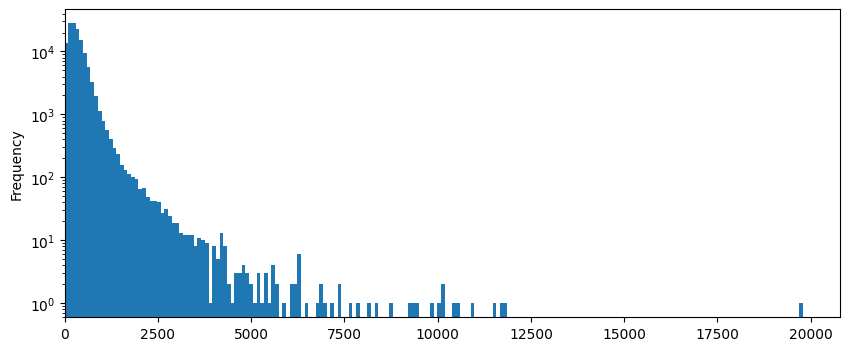

In [11]:
s = sample['content'].str.split().str.len()
plt.figure(figsize=(10, 4))
s.plot.hist(bins=200)
plt.xlim(0)
plt.yscale('log')
print("Total words:",s.sum())

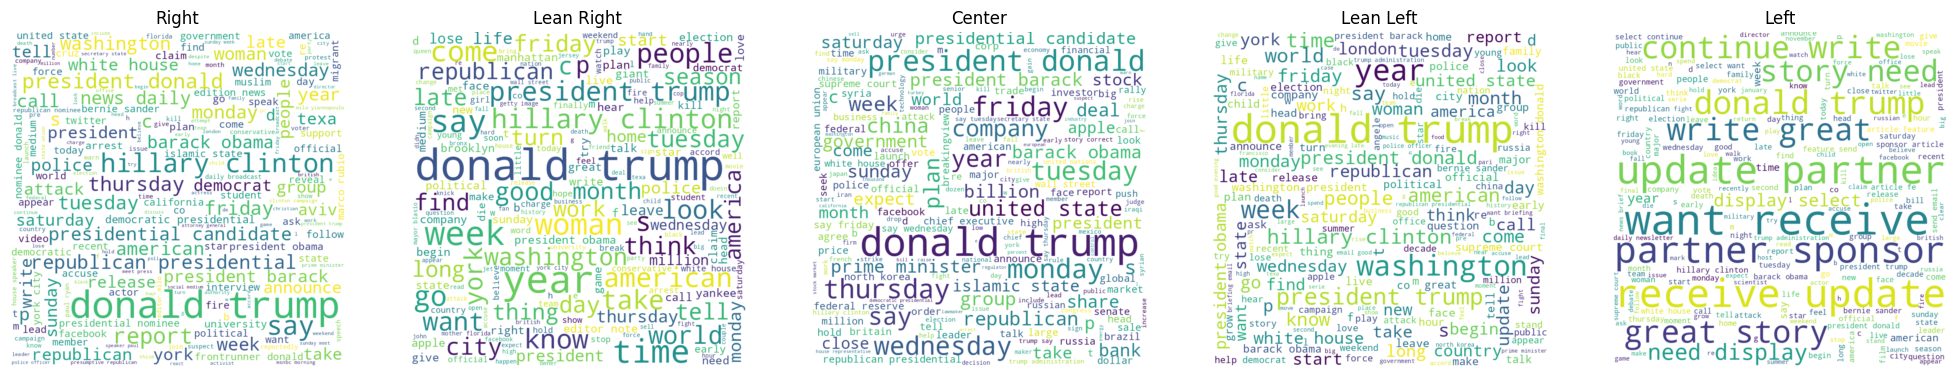

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

right_wing = sample['content'][sample['bias']=="Right"].to_string()
wordcloud_right = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(right_wing)
left_wing = sample['content'][sample['bias']=="Left"].to_string()
wordcloud_left = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(left_wing)
lean_right_wing = sample['content'][sample['bias']=="Lean Right"].to_string()
wordcloud_lean_right = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(lean_right_wing)
lean_left_wing = sample['content'][sample['bias']=="Lean Left"].to_string()
wordcloud_lean_left = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(lean_left_wing)
center_wing = sample['content'][sample['bias']=="Center"].to_string()
wordcloud_center = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(center_wing)

# Plotting the WordCloud images
plt.figure(figsize=(25, 5))

clouds = [
    (wordcloud_right, "Right"),
    (wordcloud_lean_right, "Lean Right"),
    (wordcloud_center, "Center"),
    (wordcloud_lean_left, "Lean Left"),
    (wordcloud_left, "Left"),
]

for i, (wc, title) in enumerate(clouds, 1):
    plt.subplot(1, 5, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

# plt.tight_layout()
# plt.savefig("wordcloud.png", dpi=300)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=10, max_df=0.8)

x_sample = vec.fit_transform(sample['content'])
y_sample = le.fit_transform(sample['bias'])  # use same encoder

In [14]:
# # SMOTE implementation

# from imblearn.over_sampling import SMOTE
# from collections import Counter

# print('Original dataset shape %s' % Counter(le.inverse_transform(y_sample)))

# sm = SMOTE(random_state=42)

# x_sample, y_sample = sm.fit_resample(x_sample, y_sample)
# print('Resampled dataset shape %s' % Counter(le.inverse_transform(y_sample)))


In [15]:
X_train, X_test, train_Y, test_Y = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [ ]:
#LinearSVC

svc_classifier = LinearSVC(class_weight="balanced")
svc_classifier.fit(X_train, train_Y)

svc_pred = svc_classifier.predict(X_test)

print("Accuracy:", svc_classifier.score(X_test, test_Y))
print(classification_report(le.inverse_transform(test_Y), le.inverse_transform(svc_pred)))
print(confusion_matrix(le.inverse_transform(test_Y), le.inverse_transform(svc_pred)))

Accuracy: 0.7935172257650654
              precision    recall  f1-score   support

      Center       0.98      0.97      0.98      2142
   Lean Left       0.75      0.85      0.80      9831
  Lean Right       0.76      0.69      0.72      4739
        Left       0.77      0.66      0.71      4162
       Right       0.86      0.81      0.83      5627

    accuracy                           0.79     26501
   macro avg       0.82      0.80      0.81     26501
weighted avg       0.80      0.79      0.79     26501

[[2081   42    8    9    2]
 [  20 8380  542  503  386]
 [   9 1017 3278  194  241]
 [   6 1078  222 2735  121]
 [   7  673  273  119 4555]]


In [17]:
# Save the model, vectorizer, and label encoder for later use
import joblib
import os

# Create models directory if it doesn't exist
models_dir = "./linearsvc"
os.makedirs(models_dir, exist_ok=True)

# Save the model components
joblib.dump(svc_classifier, f'{models_dir}/linearsvc_model.pkl')
joblib.dump(vec, f'{models_dir}/tfidf_vectorizer.pkl')
joblib.dump(le, f'{models_dir}/label_encoder.pkl')

print("Model, vectorizer, and label encoder saved successfully!")
print(f"Saved to: {models_dir}")

Model, vectorizer, and label encoder saved successfully!
Saved to: ./linearsvc
